In [115]:
%matplotlib inline

from io import open
import unicodedata
import string
import re
import random
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from collections import defaultdict
import time
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Рекуррентные сети 3

In [116]:
def load_data(file_path):
    print("Чтение данных...")

    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.read().strip().split('\n')

    pairs = []
    for line in lines:
        parts = line.split('\t')
        if len(parts) >= 2:  
            pairs.append((parts[0], parts[1]))  

    print(f"Загружено {len(pairs)} пар предложений.")
    return pairs

file_path = 'data/rus.txt'  
pairs = load_data(file_path)

print(f"Пример пары: {pairs[0]}")


Чтение данных...
Загружено 496059 пар предложений.
Пример пары: ('Go.', 'Марш!')


In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def prepare_data(pairs):
    input_lang = Lang("eng")
    output_lang = Lang("rus")

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print(f"Словарь английского языка: {input_lang.n_words} слов")
    print(f"Словарь русского языка: {output_lang.n_words} слов")
    return input_lang, output_lang

eng_lang, rus_lang = prepare_data(pairs)


Словарь английского языка: 36669 слов
Словарь русского языка: 105113 слов


In [118]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')] + [EOS_token]

def tensorsFromPair(pair):
    input_tensor = torch.tensor(indexesFromSentence(eng_lang, pair[0]), dtype=torch.long, device=device)
    target_tensor = torch.tensor(indexesFromSentence(rus_lang, pair[1]), dtype=torch.long, device=device)
    return (input_tensor, target_tensor)

print("Пример тензоров для пары:")
print(tensorsFromPair(pairs[0]))


Пример тензоров для пары:
(tensor([2, 1]), tensor([2, 1]))


In [119]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [120]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=10):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)

        print(f"decoder_output.size: {decoder_output.size()}, target_tensor[di].size: {target_tensor[di].size() if hasattr(target_tensor[di], 'size') else 'scalar'}")

        decoder_input = target_tensor[di]  
        loss += criterion(decoder_output, target_tensor[di].view(1))  

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [121]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f"{m}m {s}s"

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return f"{asMinutes(s)} (- {asMinutes(rs)})"

def showPlot(points):
    plt.figure()
    plt.plot(points)
    plt.xlabel("Итерации")
    plt.ylabel("Потери")
    plt.title("График потерь")
    plt.show()

def trainIters(
    encoder, decoder, n_iters, print_every=100, plot_every=100, learning_rate=0.01
):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 
    plot_loss_total = 0  

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [tensorsFromPair(random.choice(pairs)) for _ in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(
            input_tensor,
            target_tensor,
            encoder,
            decoder,
            encoder_optimizer,
            decoder_optimizer,
            criterion,
            max_length=10,
        )
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(
                "%s (%d %d%%) %.4f"
                % (timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg)
            )

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].s

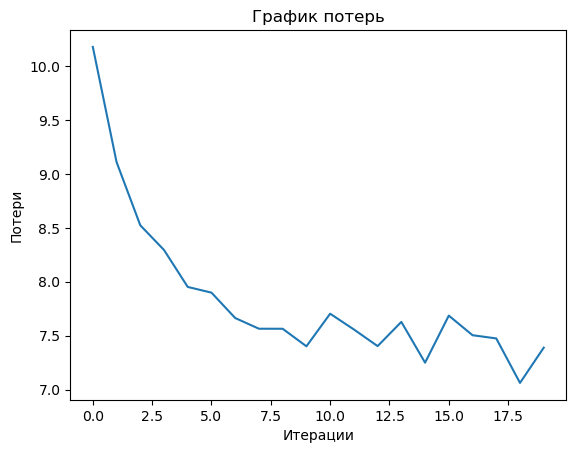

In [ ]:
hidden_size = 256
encoder = EncoderRNN(eng_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, rus_lang.n_words).to(device)

encoder_optimizer = optim.SGD(encoder.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=0.01)
criterion = nn.NLLLoss()

trainIters(
    encoder,
    decoder,
    n_iters=1000,
    print_every=100,
    plot_every=50,
    learning_rate=0.01,
)

decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].s

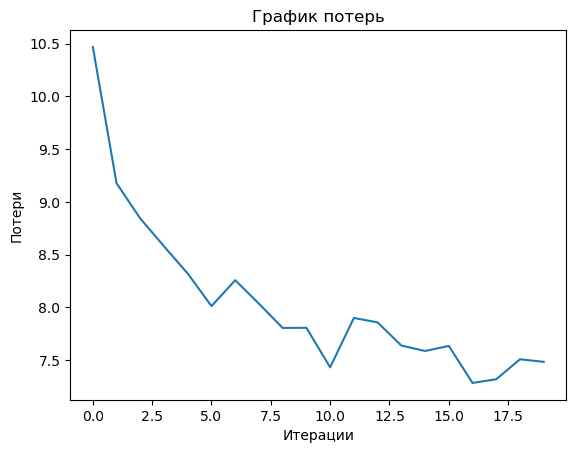

In [123]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):  
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers  

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers)  

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)  

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=2):  
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers  

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers)  
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)  

hidden_size = 256
num_layers = 2  

encoder = EncoderRNN(eng_lang.n_words, hidden_size, num_layers=num_layers).to(device)
decoder = DecoderRNN(hidden_size, rus_lang.n_words, num_layers=num_layers).to(device)

trainIters(
    encoder,
    decoder,
    n_iters=1000,
    print_every=100,
    plot_every=50,
    learning_rate=0.01,
)


In [124]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return (
            torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
            torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
            )  


In [125]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=2):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return (
            torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
            torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
        )  


decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].size: torch.Size([])
decoder_output.size: torch.Size([1, 105113]), target_tensor[di].s

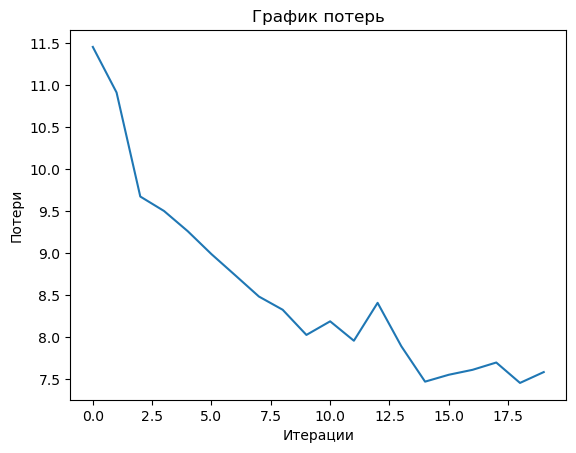

In [126]:
hidden_size = 256
num_layers = 2  

encoder = EncoderRNN(eng_lang.n_words, hidden_size, num_layers=num_layers).to(device)
decoder = DecoderRNN(hidden_size, rus_lang.n_words, num_layers=num_layers).to(device)

trainIters(
    encoder,
    decoder,
    n_iters=1000,
    print_every=100,
    plot_every=50,
    learning_rate=0.01,
)
